# Explore Zurich, Swizterland with OpenStreetMap

I just moved to Zurich last Summer. Analysis of the OpenStreetMap offers a different and interesting perspective on exploring Zurich. [Here](https://www.openstreetmap.org/relation/1690227#map=9/47.3825/8.8028) you can find the regional map of this analysis. I download the xml format of the [data](https://mapzen.com/data/metro-extracts/metro/zurich_switzerland/) and preprocessed it using python. All the following analysis will be done using `sqlite query`.  In this report, I will first talk about the problems encountered in preprocessing the data. Then I will give you an overview of the data set. Finally I will show you some intersting observations. 

# Problems encountered in preprocessing the data
The main problem is that the form of the entry values are very often with inconsistent format or even missing information. I tried to find a standard for the entry values so that the following analysis would be easier to retrieve relevant information. Here I showed 3 examples as well as my solution.  

1. The canton and district of a place are often unclearly defined or even unlabeled.
```XML
<tag k="is_in" v="Bezirk Meilen,Zürich,Schweiz,Europe" />
<tag k="is_in" v="Dübendorf,Schweiz,Europe" />
<tag k="is_in" v="Egg" />
<tag k="is_in" v="CH,Schlieren" />
<tag k="is_in" v="Pfäffikon ZH" />
```
What I did was adding **canton, district, local_name** as new 'key' and replacing the **regular** 'type' with **is_in**. Here are the steps to get information about "canton" and "district" (see `clean_format.py` for more detail): 
>2. Find canton by searching for words related to Aargau(AG) or Zurich(ZH) or Kanton(canton in German).
>3. Find district by search for word conatining 'Bezirk'(district in German) or any word in the list of districts (obtained by using BeautifulSoup to scrap [wikipedia](https://de.wikipedia.org/wiki/Bezirk_(Schweiz))).
>4. If find district, use district to fill canton. 
>5. If no information about district and canton is found, then use wikipedia API to search for the canton name.
>6. If the input information is not clear enough to get the canton or district name, the output will be empty. 

2. The format of phone number are very different. Here are some examaples:
```XML
<tag k="phone" v="+41 562090809" />
<tag k="phone" v="0432110222" />
<tag k="phone" v="+41 (0)55 615 36 67" />
<tag k="phone" v="+41 562090809" />
```
> What I did was to make every phone with this format `+41448606555` 

3. The format of opening_hours are very different. Some of them are even detailed descriptions in German. Here are some example:
```XML
<tag k="opening_hours" v="Mo-Fr 07:00-18:30, Sa 8:30-16:00" />
<tag k="opening_hours" v="Montag geschlossen  Dienstag 09:00 - 13:00 / 13:30 - 18:30  Mittwoch + Donnerstag  10:00 - 13:00 / 13:30 - 18:30  Freitag 09:00 - 13:00 / 13:30 - 18:30  Samstag 10:00 - 16:00" />
<tag k="opening_hours" v="Mo 14:00-19:00; Tu-Fr 10:00-19:00; Sa 10:00-17:00; Oct-Feb: Tu-Fr 11:00-19:00; Oct-Feb: Sa 10:00-16:00; Oct-Feb: Mo off" />
<tag k="opening_hours" v="Di.-Fr. 8:00-12:00 / 13:30-18:30; Sa. 8:00-16:00; Mo. geschlossen" />
```
The output format would be:
>`Mo off;Tu 09:00-13:00,13:30-18:30;We-Th 10:00-13:00,13:30-18:30;Fr 09:00-13:00,13:30-18:30;Sa 10:00-16:00`

# Overview of the data set
## import data

In [4]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import re
from tabulate import tabulate

## Overview of the files
### File size
* raw osm file: 611.5 MB
* nodes.csv: 212.5 MB
* nodes_tags.csv: 15.9 MB
* ways.csv: 24.6 MB
* ways_tags.csv: 43.1 MB
* ways_nodes.csv: 77.6 MB
* OpenStreetMap.db (database includes all csv files): 331.5 MB

### Number of elements in each file

In [524]:
line_nodes = pd.read_sql_query('SELECT count() FROM nodes',db)['count()']
line_nodes_tags = pd.read_sql_query('SELECT count() FROM nodes_tags',db)['count()']
line_ways = pd.read_sql_query('SELECT count() FROM ways',db)['count()']
line_ways_tags = pd.read_sql_query('SELECT count() FROM ways_tags',db)['count()']
line_ways_nodes = pd.read_sql_query('SELECT count() FROM ways_nodes',db)['count()']
dic_data = {'nodes':line_nodes,'nodes_tags':line_nodes_tags,'ways':line_ways,'ways_tags':line_ways_tags,'ways_nodes':line_ways_nodes}
df_data = pd.DataFrame(dic_data)
df_data

,nodes,nodes_tags,ways,ways_nodes,ways_tags
0,2695275,446304,429887,3298070,1264582


## Overview of the data
### Users contribute to the data set:
* Number of unique users: 2550 
* Number of users only contribute once 517
* 39 users (1.53% of all users) contribute to 80% of the data.

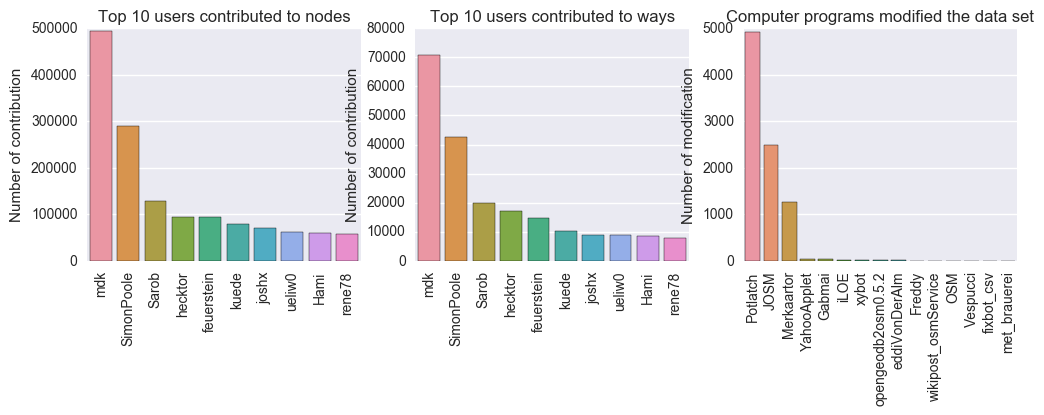

In [17]:
# users contribute most to nodes:
user_node = pd.read_sql_query('SELECT user, count() as num FROM nodes GROUP BY uid ORDER BY num DESC LIMIT 10',db)
# users contribute most to ways:
user_way = pd.read_sql_query('SELECT user, count() as num FROM ways GROUP BY uid ORDER BY num DESC LIMIT 10',db)

** About 20% of the users only contribute once. Top 10 contributors entered 53% nodes data and 49% ways data. It's quite surprising that 80% of the data were actually came from 1.53% of the contributors. 99% of the data modified by computer programs were done by OpenStreetMap editors (Potlatch, JSOM and Merkaartor).**

### Timeline of creating data

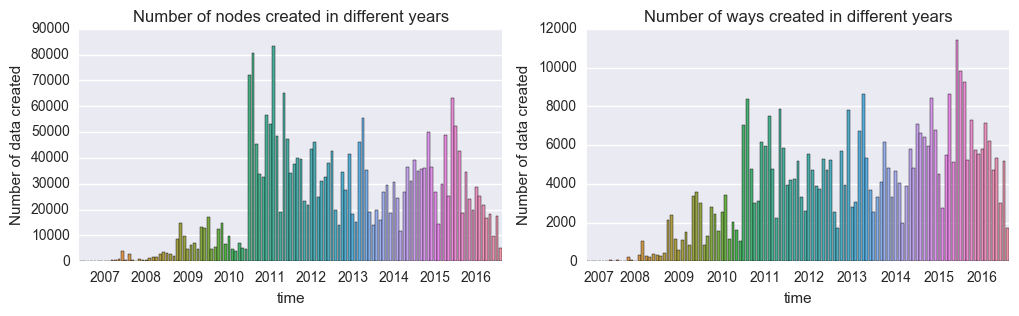

In [213]:
# timestamp of creating nodes
nodes_time = pd.read_sql_query('SELECT timestamp FROM nodes',db)
nodes_time['time'] = nodes_time['timestamp'].str.replace('[\-\d]{3}T.*Z','')
create_time_nodes = nodes_time.groupby('time').count().reset_index()
# timestamp of creating ways 
ways_time = pd.read_sql_query('SELECT timestamp FROM ways',db)
ways_time['time'] = ways_time['timestamp'].str.replace('[\-\d]{3}T.*Z','')
create_time_ways = ways_time.groupby('time').count().reset_index()
create_time = pd.concat([create_time_ways,create_time_nodes])

**OpenStreetMap was founded in 2004. It seems like that the main boost of creating data is around the end of 2010. From the figure below we can see that the boost doesn't seem to caused by the number of registered users. According to [the history of OpenStreetMap](http://wiki.openstreetmap.org/wiki/History_of_OpenStreetMap), it was around the time they embedded new editor Potlatch 2 into the homepage **
<img src="http://wiki.openstreetmap.org/w/images/7/79/Osmdbstats1_users.png" width="600px", height="350px" align="left">

### Number of ways and nodes and the corresonding tags 

In [68]:
# number of tags in each node 
node_num = pd.read_sql_query('SELECT nodes.id, count() as num \
                             FROM nodes LEFT JOIN nodes_tags \
                             ON nodes.id=nodes_tags.id \
                             GROUP BY nodes.id',db)
# number of tags in each way
way_num = pd.read_sql_query('SELECT ways.id, count() as num \
                             FROM ways LEFT JOIN ways_tags \
                             ON ways.id=ways_tags.id \
                             GROUP BY ways.id',db)

,25%,50%,75%,count,max,mean,min,std
name,,,,,,,,
node,1.0,1.0,1.0,2695275.0,123.0,1.069532,1.0,0.560818
way,1.0,2.0,4.0,429887.0,30.0,2.955439,1.0,2.130112


### Number of nodes in one way

In [570]:
df_way_nodes = pd.read_sql_query('SELECT id, count() FROM ways_nodes GROUP BY id',db)
pd.set_option('display.precision', 2)
df_way_nodes.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
num,429888.0,7.67,11.42,1.0,5.0,5.0,9.0,1530.0


### Top 5 most-tagged nodes and ways and their tags type

In [176]:
# type of most seen tags in top5 nodes with most tags
type_nodes = pd.read_sql_query('SELECT a.id as id, value, total as N_tags, type as most_tag_type, \
                   num as N_most_tag_type FROM\
                  (SELECT sum(num) as total, id, type, num FROM\
                  (SELECT id, type, count() as num FROM nodes_tags WHERE id IN\
                    (SELECT id FROM\
                   (SELECT id, count() as num FROM nodes_tags GROUP BY id ORDER BY num DESC LIMIT 10))\
                   GROUP BY id, type ORDER BY id, num)\
                   GROUP BY id ORDER BY total DESC LIMIT 5) a\
                   JOIN\
                   (SELECT id, value FROM nodes_tags WHERE key="name") b \
                   ON b.id=a.id\
                   GROUP BY a.id ORDER BY N_tags DESC LIMIT 5',db)

node                                                         \
           id             value N_tags most_tag_type N_most_tag_type   
0   240025182            Zürich    123          name             105   
1    26608880  Flughafen Zürich     50          name              34   
2  1437520591         Fällanden     30     openGeoDB              12   
3    30757710     Küsnacht (ZH)     28     openGeoDB              13   
4    29973040           Uitikon     27     openGeoDB              13   

         way                                                     \
          id                         value N_tags most_tag_type   
0  248446830  Wertstoffsammelstelle Schanz     30     recycling   
1   93699765                 Hotel Arlette     26       payment   
2  108502462                         Socar     23          fuel   
3  116433926                        Tibits     21       regular   
4  201511857            Abfallsammelstelle     21     recycling   

                   
  N_most_tag_type  
0              20  
1              10  
2              16  
3              13  
4              18

### Top 5 most common tags

In [218]:
most_node_tag = pd.read_sql_query('SELECT key, value, count() as num FROM nodes_tags GROUP BY value ORDER BY num DESC LIMIT 5',db)
most_way_tag = pd.read_sql_query('SELECT key, value, count() as num FROM ways_tags GROUP BY value ORDER BY num DESC LIMIT 5',db)
pd.concat({'node':most_node_tag,'way':most_way_tag},axis=1)

node                         way                     
          key     value     num       key        value     num
0     natural      tree  163962  building          yes  262449
1       glass       yes   18184   country           CH   44898
2  denotation     urban   16524   highway      footway   28981
3     highway  crossing    9481   highway        track   25484
4     country        CH    5598   landuse  residential   25347

**There are 6 times more nodes than ways in the data set. In general more tags are used to describe ways (1 tag for nodes but 3 tag for ways) but nodes like "Zurich" and "Zurich airport" are highly tagged. The main type of their tags are names in different language. It's very interesting to see how the tags differ in describing different places. For example, the tags for a recycling center are different recycling material; the tags for a hotel descrbe the way of payment; the tags for a gas station marked the provided fuel. **
**On average, there are about 8 nodes in one way. The source of ways with more than 1000 nodes are mostly from processing the NASA low resolution satellite imagery by Bing or Yahoo! [ref](http://wiki.openstreetmap.org/wiki/Landsat)**
**Trees are the most common tags for nodes (almost 10 times more than the second one). It's very interesting to know that people would use trees, landmarks that are not specific at all, as markers on the map. This clearly presents how _GREEN_ Zurich is.**

# Explore Zurich
## Public transportation

In [277]:
# number of bus stations
c.execute('SELECT count(DISTINCT id) FROM nodes_tags WHERE value="bus_stop"')
num_bus = c.fetchall()[0][0]
# S bahn/train
c.execute('SELECT count(DISTINCT id) FROM nodes_tags WHERE (value LIKE "Bahnhof%" OR value LIKE "% Bahnhof") AND key="name"')
num_train = c.fetchall()[0][0]

| Type          |   Number of stations |
|---------------+----------------------|
| bus station   |                 3205 |
| train station |                  340 |


## Street type

([<matplotlib.axis.XTick at 0x1224a8fd0>,
 <a list of 4 Text xticklabel objects>)

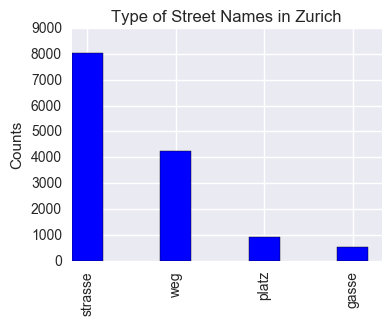

In [234]:
count_strasse = pd.read_sql_query('SELECT SUM(num) FROM\
                          (SELECT count(DISTINCT value) as num FROM nodes_tags WHERE UPPER(value) LIKE "%STRASSE%"\
                          UNION ALL\
                          SELECT count(DISTINCT value) as num FROM ways_tags WHERE UPPER(value) LIKE "%STRASSE%")\
                          ',db)

**There are 3 types of street names (strasse, weg and gasse) that you can easily see in Zurich (as well as in Germany). Simply be looking at a street, it's no way to know whether it's called strasse, weg or gasse. Platz is something like square and it also appears quite often on the map. I am interested to know how often they are actually be used. I think the result is consistent with my experience.**

## Amenity type

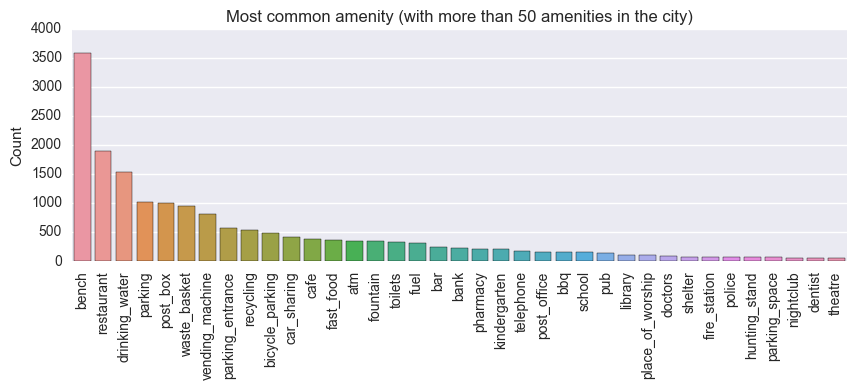

In [247]:
# Amenities with more than 50 in the city 
amenity = pd.read_sql_query('SELECT value, count(DISTINCT id) as num FROM nodes_tags WHERE key="amenity" GROUP BY value HAVING num>50 ORDER BY num DESC',db)

**I am surprised to know that bench is the most common amenity. I thought drinking water (or fontain) would be the most common amenity other than restaurants as it's very common to find fontains that are drinkable in Switzerland. Probably because usually many benches but only one fontain in a places. **
**I am also surprised that the number of pharmacy is much less than the number of fast food. I kind of having the impression that pharmacies are everywhere but I don't think I have seen many Mcdonalds, Burger king or KFC. Probably I my definition to fast food is too narrow.**

## Restaurants

There are 1893 restaurants marked in the OpenStreetMap of Zurich.
Only 292 restaurants with information about opening hours.
131 of which opens on Sunday.



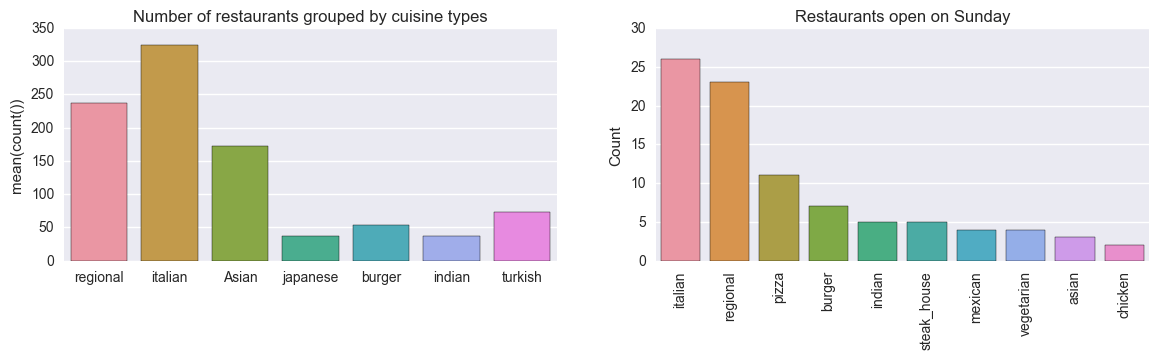

In [254]:
# total number of resutants
c.execute('SELECT count(DISTINCT id) FROM nodes_tags WHERE value="restaurant"')
total_restaurant = c.fetchall()[0][0]
# number of restaurant with infomation about opening_hours
c.execute('SELECT count(DISTINCT id) FROM nodes_tags \
           WHERE key LIKE "%opening_hours%" \
           AND id IN (SELECT id FROM nodes_tags WHERE value="restaurant")')
num_openingHour_restaurant = c.fetchall()[0][0]
# number of restaurants with opening_hours opens on Sunday
c.execute('SELECT count(DISTINCT id) FROM nodes_tags \
           WHERE key LIKE "%opening_hours%" AND value LIKE "%Su ____%" \
           AND id IN (SELECT id FROM nodes_tags WHERE value="restaurant")')
num_sun_restaurant = c.fetchall()[0][0]

print 'There are', total_restaurant ,'restaurants marked in the OpenStreetMap of Zurich.' 
print 'Only', num_openingHour_restaurant ,'restaurants with information about opening hours.' 
print num_sun_restaurant, 'of which opens on Sunday.'
print

## group these types of restaurants, to see the number:
# 1. regional, swiss, local
# 2. italian, pizza
# 3. asian, chinese, thai, vietnamese
# 4. japanese, sushi
# 5. american, burger
# 6. indian
# 7. turkish, kebab, falafel
swiss = pd.read_sql_query('SELECT value, count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%REGIONAL%" OR UPPER(value) LIKE "%SWISS%" OR UPPER(value) LIKE "%LOCAL%")',db)
pizza = pd.read_sql_query('SELECT value,count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%ITALIAN%" OR UPPER(value) LIKE "%PIZZA%")',db)
asian = pd.read_sql_query('SELECT value,count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%VIETNA%" OR UPPER(value) LIKE "%CHINESE%" OR UPPER(value) LIKE "%THAI%" OR UPPER(value) LIKE "%ASIAN%")',db)
japan = pd.read_sql_query('SELECT value,count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%JAPAN%" OR UPPER(value) LIKE "%SUSHI%")',db)
usa = pd.read_sql_query('SELECT value,count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%AMERICA%" OR UPPER(value) LIKE "%BURGER%")',db)
indian = pd.read_sql_query('SELECT value,count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%INDIAN%")',db)
kebab = pd.read_sql_query('SELECT value,count() FROM nodes_tags WHERE key="cuisine" AND\
                          (UPPER(value) LIKE "%TURKISH%" OR UPPER(value) LIKE "%KEBAB%" OR UPPER(value) LIKE "%FALAFEL%")',db)
type_cuisine = pd.concat([swiss,pizza,asian,japan,usa,indian,kebab])
type_cuisine.loc[type_cuisine['value']=='vietnamese','value']='Asian'

**it's very interesting to know that even though Zurich is in the German-speaking part of Switzerland, Italian cuisine is most common (if we regard pizza as italian food). Regional cuisine would be the second, then asian cuisine. There are 1893 restaurants shown in the map but only 15% of them having information about opening hours. I always feel it's difficult to find a restaurant open on Sunday and this analysis confirms my thoughts: less than half of restaurnats with information about opening hours open on Sunday.**

## Bank

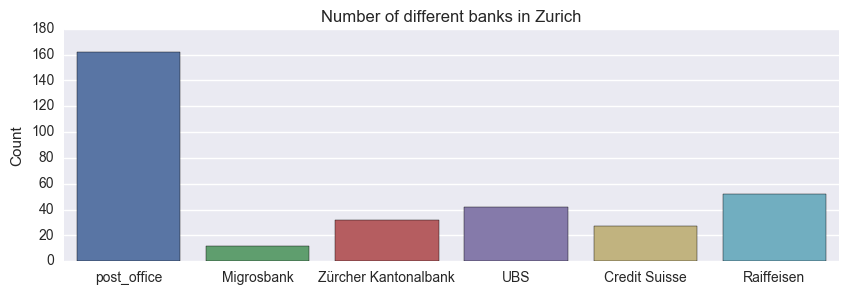

In [288]:
# number of post office (as well as number of finance post-bank of post office)
post = pd.read_sql_query('SELECT value,count(DISTINCT id) FROM nodes_tags WHERE key="amenity" AND UPPER(value) LIKE "%POST%OFFICE"',db)
# number of migros bank
migros_bank = pd.read_sql_query('SELECT value, count(DISTINCT id) FROM nodes_tags WHERE UPPER(value) LIKE "%MIGROS%BANK%" AND key="name"',db)
# number of ZKB
zkb = pd.read_sql_query('SELECT value, count(DISTINCT id) FROM nodes_tags WHERE UPPER(value) LIKE "%KANTONAL%BANK%" AND key="name"',db)
# number of UBS
ubs = pd.read_sql_query('SELECT value, count(DISTINCT id) FROM nodes_tags WHERE value LIKE "UBS%" AND key="name"', db)
# number of credit suisse
credit_suisse = pd.read_sql_query('SELECT value, count(DISTINCT id) FROM nodes_tags WHERE value LIKE "%credit suisse%" AND key="name"',db)
# number of Raiffeisen
Raiffeisen = pd.read_sql_query('SELECT value, count(DISTINCT id) FROM nodes_tags WHERE value LIKE "%Raiffeisen%" AND key="name"',db)
# all banks above
all_bank = pd.concat([post,migros_bank,zkb,ubs,credit_suisse,Raiffeisen])

**Switzerland is most famous for its bank and Zurich is the center of the bank business. This analysis shows that using _postfinance_, the bank service provided by the post office, is very convenient. Besides the 6 biggest and most common banks shown above, there are also some small regional bank (with only 1-3 banks in a small region). **

## Supermarket 
Supermarkets are most related to our lives. In Zurich, the most seen supermarkets are **Migros, Coop, Denner, Aldi Suisse, and Lidl**. Migros and Coop are Switzerland's largest retail companies. They have business not only in supermarkets, but also in housewares, banks or gas stations (only Migros). Denner also belongs to Migros but you can feel that they aim to differnt customers: the price is usually cheaper in Denner, whereas the food is more organic in Migros. Aldi and Lidl are actually supermarkets in Germany (but you can also find them in many european countries).

I am interested to know the number of different supermarkets. Moreover, if they tend to open in the same region.

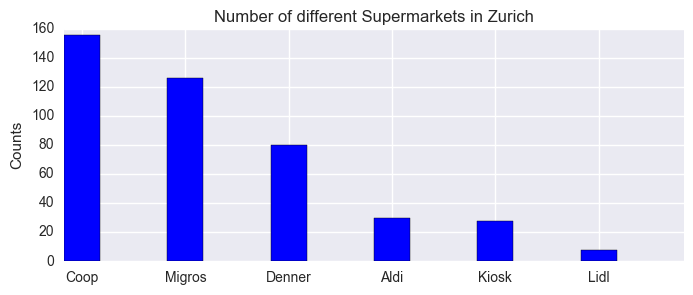

In [289]:
# number of Denner supermarket
c.execute('SELECT count(DISTINCT id) FROM nodes_tags WHERE value="Denner" AND key="name"')
denner = c.fetchall()[0][0]
# number of migros supermarket
c.execute('SELECT count(DISTINCT id) FROM nodes_tags \
           WHERE (UPPER(value)="MIGROS" OR UPPER(value)="MIGROLINO" OR UPPER(value) LIKE "MIGROS M%") \
           AND key="name"')
migros = c.fetchall()[0][0]
# number of coop supermarket
c.execute('SELECT count(DISTINCT id) FROM nodes_tags \
           WHERE UPPER(value)="COOP" OR UPPER(value)="COOP PRONTO" OR value="Coop City"')
coop = c.fetchall()[0][0]
# number of Aldi
c.execute('SELECT count(DISTINCT id) FROM nodes_tags WHERE UPPER(value) LIKE "%ALDI%" AND key="name"')
aldi = c.fetchall()[0][0]
# number of Lidl
c.execute('SELECT count(DISTINCT id) FROM nodes_tags WHERE UPPER(value) LIKE "%LIDL%" AND key="name"')
lidl = c.fetchall()[0][0]
# number of kiosk
c.execute('SELECT count(DISTINCT id) FROM nodes_tags WHERE value LIKE "Kiosk" AND key="name"')
kiosk = c.fetchall()[0][0]

**I didn't include small-sized Coop (called Coop Pronto) or Migros (called Migrolino) in this analysis because they are more like convenience stores. In this analysis we can see that Coop has the most "normal supermarket". However, the number Migros+Denner is larger than Coop. According to [wikipedia,](https://en.wikipedia.org/wiki/Migros) Migros is the largest retail company in Switzerland, suggesting the benefits of customized grocery.   **

**The number of Aldi and Lidl are much less than the two largest retail companies. I am surprised that there are not so many kiosk (small shops selling newspapers, refreshments, snacks etc) in Zurich. It's likely that they are too small to be marked. **

In [579]:
# number of migros related shops
c.execute('SELECT count(DISTINCT id) FROM nodes_tags WHERE UPPER(value) LIKE "%MIGRO%" AND key="name"')
migros_related = c.fetchall()[0][0]
# number of coop related shops
c.execute('SELECT count(DISTINCT id) FROM nodes_tags WHERE UPPER(value) LIKE "%COOP%" AND key="name"')
coop_relate = c.fetchall()[0][0]
print tabulate([['migros_related', migros_related], ['coop_related', coop_relate]], headers=['Name', 'Number of shops'], tablefmt='orgtbl')

| Name           |   Number of shops |
|----------------+-------------------|
| migros_related |               226 |
| coop_related   |               211 |


**Here the "migros related shops" actually exclude Denner. This just consider all business with the name of _Migros_ (or name of _Coop_) on it (e.g., Migrol for gas station, Migros bank, Migros restaurant). This clearly shows that Migros is without doubt the largest retail company in Switzerland.**

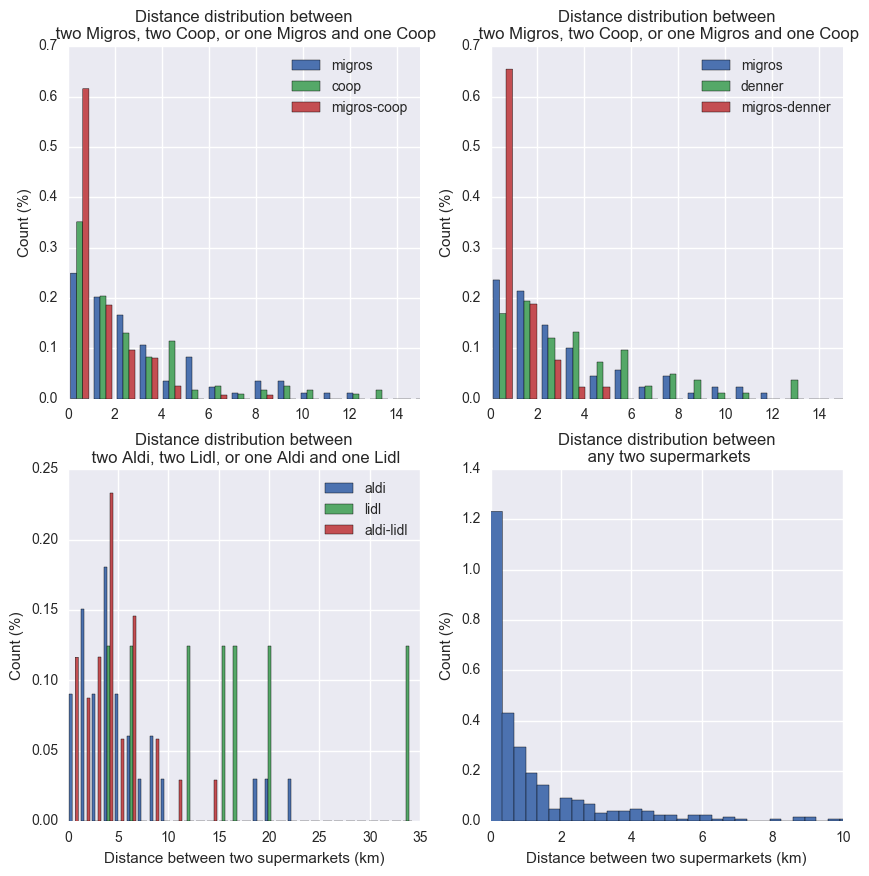

In [568]:
## summary of distances
sum_migro = pd.DataFrame(miogro2).describe().rename(columns={0:'migros'})
sum_coop = pd.DataFrame(coop2).describe().rename(columns={0:'coop'})
sum_migro_coop = pd.DataFrame(coop_migro).describe().rename(columns={0:'migros-coop'})
sum_denner = pd.DataFrame(denner2).describe().rename(columns={0:'denner'})
sum_migro_denner = pd.DataFrame(migro_denner).describe().rename(columns={0:'migros-denner'})
sum_aldi = pd.DataFrame(aldi2).describe().rename(columns={0:'aldi'})
sum_lidl = pd.DataFrame(lidl2).describe().rename(columns={0:'lidl'})
sum_aldi_lidl = pd.DataFrame(aldi_lidl).describe().rename(columns={0:'aldi-lidl'})
sum_all = pd.DataFrame(all_shops).describe().rename(columns={0:'all'})
pd.concat([sum_migro,sum_coop,sum_migro_coop,sum_denner,sum_migro_denner,sum_aldi,sum_lidl,sum_aldi_lidl,sum_all],axis=1).transpose()

,count,mean,std,min,25%,50%,75%,max
migros,86.0,3.74,4.82,1.80e-02,1.08,2.13,4.85,29.40
coop,125.0,2.89,3.44,3.12e-02,0.83,1.59,3.86,24.90
migros-coop,126.0,1.22,1.39,2.23e-02,0.25,0.76,1.69,8.80
denner,80.0,4.16,4.35,1.56e-01,1.63,3.07,5.37,31.08
migros-denner,87.0,0.87,1.09,4.70e-03,0.09,0.43,1.49,4.95
aldi,29.0,5.77,5.67,1.36e-02,2.11,4.28,6.04,22.37
lidl,7.0,15.57,9.95,4.40e+00,9.13,15.82,18.08,34.36
aldi-lidl,30.0,4.60,3.17,2.68e-01,2.61,4.23,6.15,14.23
all,359.0,1.44,2.42,4.70e-03,0.15,0.52,1.58,19.82


**It's very interesting to know that Migros and Coop like to open close to each other (the distances between one Migros and one Coop is much smaller than two Migros or two Coops), suggesting location is indeed a key to the business. Denner also opens very close to Migros so that they can really provide customized grocery shopping. Some (about 10%) Aldi and Lidl open close to each other. **

# Conclusion

Analyzing the map indeed provides very different and insightful aspects to explore the city. The map is however, not completed. In particular, detailed information about restaurants, shops or government agencies. These are information that are difficult to obtained by GPS or satellite images. Google starts the "local guides" projects for people from all over the world to contribute information. This is a brilliant idea but another more efficient approach to get the completed and consistent information is probably to collaborate with governments and companies, especially those with many chain stores. Information about small shops or restaurnats would be harder to obtain.  Trip advisors or Yelp would probably a good source for getting more detailed information about restaurants. If it's a big shopping mall/center/street, the mangaging company of the whole mall could probably provide detailed information about individual small stores. Social networks like facebook or twitter could also be a good source to get local information but it's probably a bit difficult to filter "right" and "useful" information.

GPS track and satellite images together can be a great method for creating reliable data of way. The estimated moving speed can even provide information such as traffic load and road status (easy to go or bumpy). This can probably be done in an effective way by collaborating with bus companies or Uber.

I think OpenStreetMap is an excellent project. But it's not really well-known. The more people participate in creating and managing the database, the better it would be. With the technologies today, everyone can easily provide detailed GPS track. The most important thing lacking now is probably a good app that allows everyone to do it easily. I believe, once people can easily record their trip, manage it and upload it to the database, it would become a habbit to them and this would allow the database of OpenStreetMap to grow and be well maintained.